# Analysis

Let's benchmark against all tool usage tasks. 

Expand the models list to benchmark with different models.

In [1]:
import datetime

from langsmith.client import Client

from langchain_benchmarks import (
    __version__,
    clone_public_dataset,
    model_registry,
    registry,
)
from langchain_benchmarks.rate_limiting import RateLimiter
from langchain_benchmarks.tool_usage.agents import (
    AnthropicToolUserFactory,
    CustomAgentFactory,
    OpenAIAgentFactory,
    OpenAIAssistantFactory,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langsmith.client import Client

In [2]:
from datetime import datetime
client = Client()

In [26]:
experiment_ids = ["woof"]


def _endswith(s, suffixes):
    return any(s.endswith(suffix) for suffix in suffixes)


client = Client()
projects = [
    project
    for project in client.list_projects()
    if _endswith(project.name, experiment_ids)
]

print("\n".join(sorted([project.name for project in projects])))

claude-2.1-anthropic_tool_user-Multiverse Math-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Relational Data-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Multiverse Math-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Relational Data-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Multiverse Math-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Relational Data-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gpt-3.5-turbo-1106-openai_functions-Multiverse Math-2023-

In [8]:
dfs = []
for project in projects:
    # Temporary way to get tag information
    project_info = client.read_project(project_id=project.id)
    
    if project_info.extra is None:
        raise ValueError(project.name)
    try:
        test_results = client.get_test_results(project_name=project.name)
    except Exception:
        continue

    for k, v in project_info.extra["metadata"].items():
        test_results[k] = v

    dfs.append(test_results)


df = pd.concat(dfs)

Compute a standardized "correct" column. It uses "Correct Final State" for tool usage tasks, and "correctness (which is based on output) for the other tasks.

In [9]:
correct = []

for r in df.to_dict(orient="records"):
    if "Typewriter" in r["task"]:
        correct.append(r["feedback.Correct Final State"])
    else:
        correct.append(r["feedback.correctness"])

df["correct"] = correct
df["correct"].fillna(0, inplace=True)

Compute some statistics. We're using estimating standard error of the mean assuming a bernoulli process.

In [127]:
num_correct = df.groupby(["model", 'arch', "task"])["correct"].sum().to_frame("num_correct")
total = df.groupby(["task", 'arch', "model"]).size().to_frame("total")
stats_df = total.join(num_correct)
stats_df["% correct"] = stats_df["num_correct"] / stats_df["total"]
stats_df["error"] = np.sqrt(
    stats_df["% correct"] * (1 - stats_df["% correct"]) / stats_df["total"]
)


tasks = [
    "Tool Usage - Typewriter (1 tool)",
    "Tool Usage - Typewriter (26 tools)",
    "Multiverse Math",
    "Tool Usage - Relational Data",
]

stats_df = stats_df.reset_index()

In [128]:
names = []
for r in stats_df.to_dict(orient='records'):
    if r['model'].startswith('gpt'):
        if r['arch'] == "openai_assistant":
            names.append(f"{r['model']} (assistant)")
        else:
            names.append(f"{r['model']} (functions)")
    elif r['model'].endswith('-fw'):
        names.append(r['model'].removesuffix('-fw'))
    else:
        names.append(r['model'])
    

In [129]:
stats_df['model'] = names

In [141]:
models = stats_df.set_index('task').loc['Tool Usage - Relational Data'].sort_values('% correct')['model'].to_list()

In [142]:
models

['llama-v2-70b-chat',
 'yi-34b-200k',
 'llama-v2-13b-chat',
 'mistral-7b-instruct-v0.1',
 'mixtral-8x7b-instruct',
 'claude-2.1',
 'gpt-3.5-turbo-1106 (functions)',
 'gpt-3.5-turbo-1106 (assistant)',
 'gpt-3.5-turbo-0613 (functions)',
 'gpt-4-1106-preview (assistant)',
 'gpt-4-0613 (functions)',
 'gpt-4-1106-preview (functions)']

In [143]:
models = [
 'llama-v2-13b-chat',
 'llama-v2-70b-chat',
  'yi-34b-200k',
 'mistral-7b-instruct-v0.1',
 'mixtral-8x7b-instruct',
 'claude-2.1',
 'gpt-3.5-turbo-0613 (functions)',
 'gpt-3.5-turbo-1106 (functions)',
 'gpt-3.5-turbo-1106 (assistant)',
 'gpt-4-0613 (functions)',
 'gpt-4-1106-preview (functions)',
    'gpt-4-1106-preview (assistant)',
]

In [144]:
stats_df

,task,arch,model,total,num_correct,% correct,error
0,Multiverse Math,anthropic_tool_user,claude-2.1,10,5.0,0.500000,0.158114
1,Multiverse Math,custom_agent,llama-v2-13b-chat,10,0.0,0.000000,0.000000
2,Multiverse Math,custom_agent,llama-v2-70b-chat,10,2.0,0.200000,0.126491
3,Multiverse Math,custom_agent,mixtral-8x7b-instruct,10,3.0,0.300000,0.144914
4,Multiverse Math,custom_agent,yi-34b-200k,10,0.0,0.000000,0.000000
5,Multiverse Math,openai_assistant,gpt-3.5-turbo-1106 (assistant),10,7.0,0.700000,0.144914
6,Multiverse Math,openai_assistant,gpt-4-1106-preview (assistant),10,4.0,0.400000,0.154919
7,Multiverse Math,openai_functions,gpt-3.5-turbo-0613 (functions),10,8.0,0.800000,0.126491
8,Multiverse Math,openai_functions,gpt-3.5-turbo-1106 (functions),10,6.0,0.600000,0.154919
9,Multiverse Math,openai_functions,gpt-4-0613 (functions),10,6.0,0.600000,0.154919


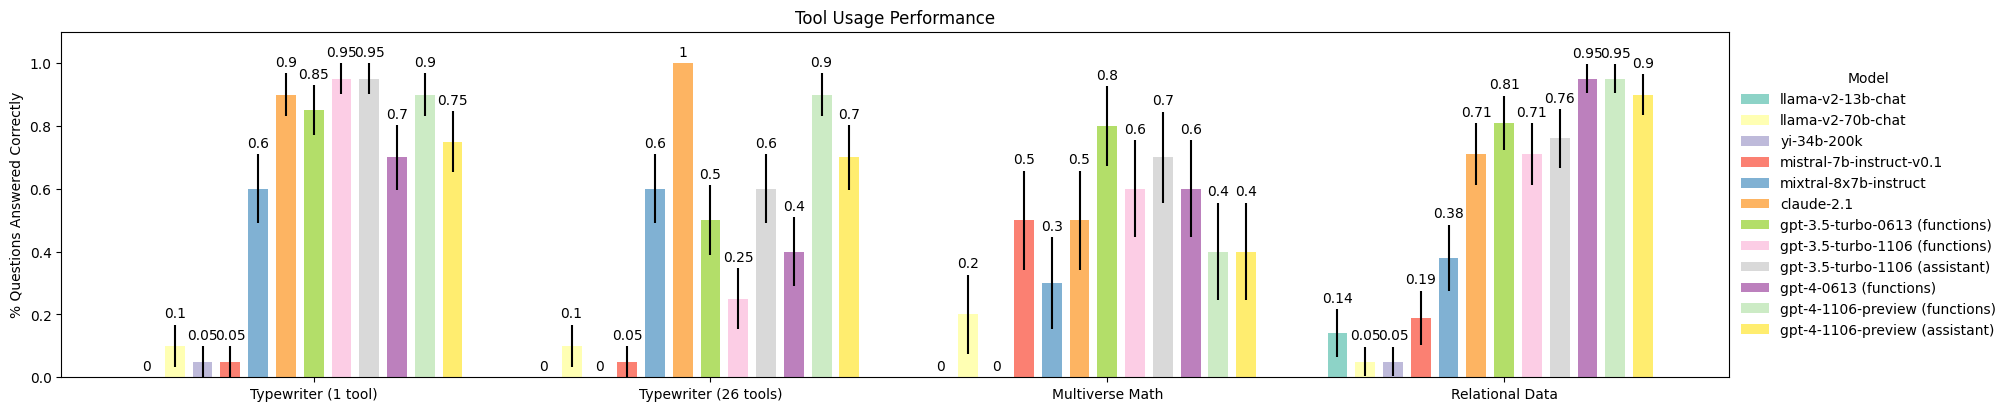

In [145]:
x = np.arange(len(tasks))  # the label locations
width = 0.05  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(20, 4))
colormap = plt.get_cmap("Set3").colors

for idx, model in enumerate(models):
    try:
        results = stats_df.set_index("model").loc[model]
    except:
        continue

    color = colormap[idx]
    
    
    errors = []
    values = []
    for task in tasks:
        try:
            result = results.set_index("task").loc[task]
            values.append(round(result['% correct'], 2))
            errors.append(result['error'])
        except KeyError:
            values.append(np.nan)
            errors.append(np.nan)
        

    offset = width * multiplier * 1.4
    rects = ax.bar(
        x + offset, values, width, label=model, yerr=errors, color=color
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("% Questions Answered Correctly")
ax.set_title("Tool Usage Performance")

labels = [
    task.removeprefix('Tool Usage - ')
    for task in tasks
]

ax.set_xticks(x + width + 0.37, labels)
ax.legend(
    loc="center left", ncols=1, bbox_to_anchor=(1.0, 0.5), frameon=False, title="Model"
)
ax.set_ylim(0, 1.10)

plt.show()

In [135]:
# x = np.arange(len(tasks))  # the label locations
# width = 0.08  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout="constrained", figsize=(16, 4))
# colormap = plt.get_cmap("Set2").colors

# for idx, model in enumerate(models):
#     try:
#         results = stats_df.set_index("model").loc[model]
#     except:
#         continue

#     color = colormap[idx]
    
    
#     errors = []
#     values = []
#     for task in tasks:
#         try:
#             result = results.set_index("task").loc[task]
#             values.append(round(result['% correct'], 2))
#             errors.append(result['error'])
#         except KeyError:
#             values.append(np.nan)
#             errors.append(np.nan)
        

#     offset = width * multiplier * 1.4
#     rects = ax.bar(
#         x + offset, values, width, label=model, yerr=errors, color=color
#     )
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel("% Questions Answered Correctly")
# ax.set_title("Tool Usage Performance")

# labels = [
#     task.removeprefix('Tool Usage - ')
#     for task in tasks
# ]

# ax.set_xticks(x + width + 0.25, labels)
# ax.legend(
#     loc="center left", ncols=1, bbox_to_anchor=(1.0, 0.5), frameon=False, title="Model"
# )
# ax.set_ylim(0, 1.10)

# plt.show()

In [136]:
subset_df = stats_df.set_index('task').loc['Tool Usage - Relational Data']

In [137]:
subset_df

,arch,model,total,num_correct,% correct,error
task,,,,,,
Tool Usage - Relational Data,anthropic_tool_user,claude-2.1,21,15.0,0.714286,0.098581
Tool Usage - Relational Data,custom_agent,llama-v2-13b-chat,21,3.0,0.142857,0.076360
Tool Usage - Relational Data,custom_agent,llama-v2-70b-chat,21,1.0,0.047619,0.046471
Tool Usage - Relational Data,custom_agent,mixtral-8x7b-instruct,21,8.0,0.380952,0.105971
Tool Usage - Relational Data,custom_agent,yi-34b-200k,21,1.0,0.047619,0.046471
Tool Usage - Relational Data,openai_assistant,gpt-3.5-turbo-1106 (assistant),21,16.0,0.761905,0.092943
Tool Usage - Relational Data,openai_assistant,gpt-4-1106-preview (assistant),21,19.0,0.904762,0.064056
Tool Usage - Relational Data,openai_functions,gpt-3.5-turbo-0613 (functions),21,17.0,0.809524,0.085689
Tool Usage - Relational Data,openai_functions,gpt-3.5-turbo-1106 (functions),21,15.0,0.714286,0.098581


In [138]:
subset_df.loc['model']


KeyError: 'model'

In [139]:
models = subset_df.model.to_list()
pct_correct = subset_df['% correct']
error = subset_df['error']

In [140]:
models

['claude-2.1',
 'llama-v2-13b-chat',
 'llama-v2-70b-chat',
 'mixtral-8x7b-instruct',
 'yi-34b-200k',
 'gpt-3.5-turbo-1106 (assistant)',
 'gpt-4-1106-preview (assistant)',
 'gpt-3.5-turbo-0613 (functions)',
 'gpt-3.5-turbo-1106 (functions)',
 'gpt-4-0613 (functions)',
 'gpt-4-1106-preview (functions)',
 'mistral-7b-instruct-v0.1']

TypeError: tuple indices must be integers or slices, not tuple

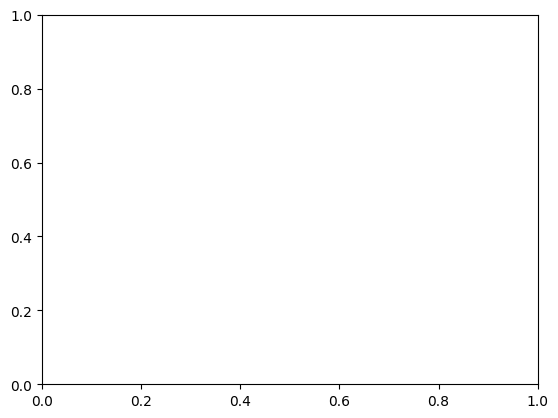

In [95]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# colormap = plt.get_cmap("Set3").colors

# c = [colormap[idx] for idx in enumerate(models)]
# fruits = ['apple', 'blueberry', 'cherry', 'orange']
# counts = [40, 100, 30, 55]
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("% Questions Answered Correctly")
ax.set_title("Tool Usage Performance")


ax.bar(models, pct_correct)

ax.set_ylabel('fruit supply')
ax.set_title('Fruit supply by kind and color')
# ax.legend(title='Fruit color')

plt.show()